### This notebook is meant to be run in Colab. It clones data and code from the GitHub repo.

In [1]:
# Installs packages and clones GitHub repo to Colab
!pip install import-ipynb # to import functions from other ipynb files
!git clone https://github.com/peepkolberg/CNS-EOG-classifier.git
%cd CNS-EOG-classifier/

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=32927cdb38cb4aeffd64dc5e7971437c9903fc70548bb8bd25d7a2ed0b3c3974
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
Cloning into 'CNS-EOG-classifier'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 107 (delta 31), reused 50 (delta 18), pack-reused 43
Receiving objects: 100% (107/107), 22.20 MiB | 31.35 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/CNS-EOG-classifier


In [18]:
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import preprocess    #import the preprocess notebook
plt.rcParams.update({'font.size': 18})


In [8]:
# Various data preparing functions. 
import copy

def safely_remove_distraction_classes(datasets_dict):
    """
    Removes the distraction classes (labels 7 and 8) from the datasets without concatenating the surrounding class.
    Since each distraction is in the middle of another class, this function separates the surrounding class into two parts.
    The parts will be denoted by appending .1 or .2 to the surrounding class labels that are before and after the distraction class, respectively.
    """
    for participant, experiments in datasets_dict.items():
        for experiment, df in experiments.items():
            for dis_label in (7, 8):
                dis_df_idx = df[df['class'] == dis_label].index
    
                dis_start_idx = dis_df_idx[0]
                dis_end_idx = dis_df_idx[-1]
        
                surrounding_class_label = df['class'][dis_start_idx - 1]
            
                before_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index < dis_start_idx) ]
                after_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index > dis_end_idx) ]
                
                df.loc[before_dis_class.index[0] : dis_start_idx, 'class'] = surrounding_class_label + 0.1
                df.loc[after_dis_class.index[0] : after_dis_class.index[-1]+1, 'class'] = surrounding_class_label + 0.2
                
                df.drop(index=range(dis_start_idx, dis_end_idx+1), inplace=True)
                #print(df['class'].unique())

def data_split(df, data_columns, chunk_size, window_step):
  """
  Outputs: NumPy arrays of data (X) and labels (y)

  Splits time-series data into equal-sized chunks.
  Also removes the .1 and .2 from previously separated labels.
  """

  X = []
  y = []

  for label in df['class'].unique():
    class_df = df[df['class'] == label]

    signals = np.asarray(class_df[data_columns])
    
    for i in range(0, len(signals), window_step): 
      chunk = signals[i : i + chunk_size]

      if len(chunk) != chunk_size:
        break

      X.append(chunk)
      y.append(int(label))

  return np.asarray(X), np.asarray(y) - 1    # Subtracting 1 from labels because keras tools expect numerical labels to start from 0

def split_datasets(datasets_dict, data_columns, chunk_size, sliding_window_step = -1):
  """ 
  Input: datasets_dict - 2D dictionary; hierarchy: dict[participant][experiment]
  Splits each dataset into chunks. If sliding_window_step argument is given, applies sliding window sampling.
  Also separates signal data (X) and labels (y).
  """

  # If step is not passed, move the window by the entire length of the window.
  if sliding_window_step == -1:
    sliding_window_step = chunk_size

  for participant, exps in datasets_dict.items():
    for experiment, data in exps.items():
      X, y = data_split(data, data_columns, chunk_size, sliding_window_step)
      datasets_dict[participant][experiment] = {'X': X, 'y': y} # <-- To also rename labels to their corresponding words, use rename_labels(y) instead of y

def one_hot_encode_labels(datasets_dict):
  for exps in datasets_dict.values():
    for data in exps.values():
      data['y'] = to_categorical(data['y'])

def print_data_dimensions(datasets_dict, cols):
  print('Rows in each experiment...')
  total_rows = 0
  total_labels = 0
  for participant, experiments in datasets_dict.items():
    for experiment, data in experiments.items():
      print(f"participant:{participant}   experiment:{experiment}")
      sig_shape = np.shape(data[cols])
      lab_shape = np.shape(data['class'])
      print(f"signals shape:{sig_shape}")
      print(f" labels shape:{lab_shape}")
      total_rows += sig_shape[0]
      total_labels += lab_shape[0]
  print(f"\nTotal {total_rows} rows of data and {total_labels} labels.")
  assert total_rows == total_labels

def concat_datasets(datasets_dict, participants, data_columns):
  X = []
  y = []

  for p in participants:
    for e in datasets_dict[p]:
      X.append(datasets_dict[p][e][data_columns])
      y.append(datasets_dict[p][e]['class'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y

def labels_to_words(numerical_labels):
    """ 
    For converting labels from numbers (0-7) to their word representations ('null', 'read', etc.)
    Input: numerical labels as a 1D array. 
    """
    replacements = {0: 'null', 
                    1: 'read', 
                    2: 'browse', 
                    3: 'write', 
                    4: 'video', 
                    5: 'copy', 
                    6: 'disspeak', 
                    7: 'disphone'}
    return np.asarray([replacements[old_label] for old_label in numerical_labels])

def plot_conf_matrix(true_labels, predictions):
  fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, predictions)).plot(cmap=plt.cm.Blues)
  plt.title(f"Participant {testing_participant} confusion matrix")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  plt.show()

def standardize(standardized_dict, datasets_dict, participants, data_columns, scaler):
  for p in participants:
    standardized_dict[p] = {}
    
    for e, experiment_data in datasets_dict[p].items():
      standardized_dict[p][e] = pd.DataFrame(data = scaler.transform(experiment_data[data_columns]), columns = data_columns)
      standardized_dict[p][e]['class'] = copy.deepcopy(datasets_dict[p][e]['class'])

  return standardized_dict

def concat_chunks(datasets_dict, participants):
  X = []
  y = []

  for p in participants:
    for e in datasets_dict[p]:
      X.append(datasets_dict[p][e]['X'])
      y.append(datasets_dict[p][e]['y'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y



# UNUSED FUNCTIONS

def normalize_per_dataset(datasets_dict, data_columns):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      for col_name in data_columns:
        initial = np.asarray(data[col_name])
        max, min = np.max(initial), np.min(initial)
        normalized = 2 * ( (initial-min) / (max-min) ) - 1 # normalize between -1 and 1
        data[col_name] = normalized

def grid_search(X_train, y_train, X_test, y_test):
  model = KerasClassifier(build_fn=compile_model, verbose=0)

  batch_size = [10, 20, 30, 40, 60, 80, 100]
  epochs = [10, 20, 30, 50, 70, 100]
  optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  cnn_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dense_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

  param_grid = dict(batch_size=batch_size,
                    epochs=epochs, 
                    optimizer=optimizer, 
                    cnn_activation=cnn_activation, 
                    dense_activation=dense_activation, 
                    dropout_rate=dropout_rate
                    )
  
  X = np.concatenate([X_train, X_test])
  y = np.concatenate([y_train, y_test])
  test_fold = np.concatenate([np.repeat(-1, len(y_train)), np.repeat(0, len(y_test))])
  
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=PredefinedSplit(test_fold=test_fold))
  grid_result = grid.fit(X, y)

  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [4]:
# Read files into dataframes (see function description in preprocess.ipynb for details)
datasets_dict = preprocess.read_all_files()

# Remove distraction classes
# The classes that surround the distraction class will be split into two parts by appending .1 or .2 to the label. 
safely_remove_distraction_classes(datasets_dict)

# Define which columns contain the desired signal data
data_columns = [
                #'signal_horizontal', 
                #'signal_vertical', 
                'signal_horizontal_nk', 
                'signal_vertical_nk'
                ]

# Normalization/standardization,
# splitting into chunks, and 
# one-hot-encoding labels is done in the training loop.

# Print the final dimensions of each dataset
print_data_dimensions(datasets_dict, data_columns)

Rows in each experiment...
participant:1   experiment:0
signals shape:(95555, 2)
 labels shape:(95555,)
participant:1   experiment:1
signals shape:(153837, 2)
 labels shape:(153837,)
participant:2   experiment:0
signals shape:(216969, 2)
 labels shape:(216969,)
participant:2   experiment:1
signals shape:(113083, 2)
 labels shape:(113083,)
participant:3   experiment:0
signals shape:(213370, 2)
 labels shape:(213370,)
participant:3   experiment:1
signals shape:(219878, 2)
 labels shape:(219878,)
participant:4   experiment:0
signals shape:(194701, 2)
 labels shape:(194701,)
participant:4   experiment:1
signals shape:(191298, 2)
 labels shape:(191298,)
participant:5   experiment:0
signals shape:(204106, 2)
 labels shape:(204106,)
participant:5   experiment:1
signals shape:(174829, 2)
 labels shape:(174829,)
participant:6   experiment:0
signals shape:(207580, 2)
 labels shape:(207580,)
participant:6   experiment:1
signals shape:(184430, 2)
 labels shape:(184430,)
participant:7   experiment:


Started training for participant 1

Training data shape:   (3078, 1280, 2)   labels shape: (3078, 6)
Validation data shape: (770, 1280, 2)     labels shape: (770, 6)
Testing data shape:    (357, 1280, 2)    labels shape: (357, 6)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 1278, 8)           56        
                                                                 
 max_pooling1d_56 (MaxPoolin  (None, 639, 8)           0         
 g1D)                                                            
                                                                 
 conv1d_57 (Conv1D)          (None, 635, 16)           656       
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 317, 16)          0         
 g1D)                                                            
                   

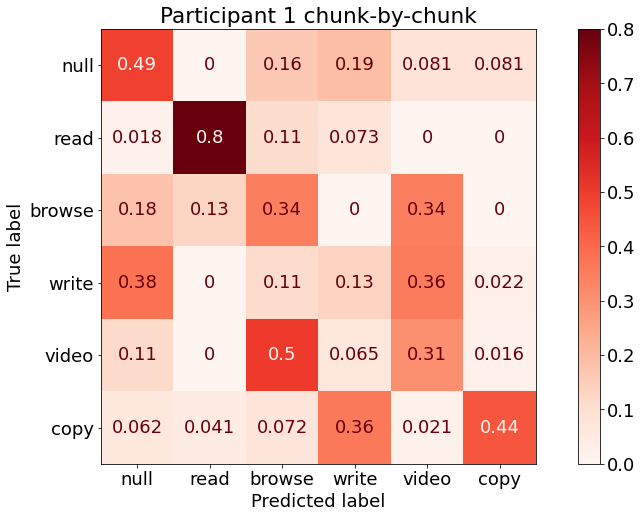


Started training for participant 2

Training data shape:   (2978, 1280, 2)   labels shape: (2978, 6)
Validation data shape: (745, 1280, 2)     labels shape: (745, 6)
Testing data shape:    (482, 1280, 2)    labels shape: (482, 6)

Epoch 1/25
166/166 [==============================] - 3s 11ms/step - loss: 3.9564 - accuracy: 0.2831 - val_loss: 1.9675 - val_accuracy: 0.3181
Epoch 2/25
166/166 [==============================] - 2s 9ms/step - loss: 1.8411 - accuracy: 0.3932 - val_loss: 1.7805 - val_accuracy: 0.4067
Epoch 3/25
166/166 [==============================] - 2s 9ms/step - loss: 1.7190 - accuracy: 0.4144 - val_loss: 1.6808 - val_accuracy: 0.4282
Epoch 4/25
166/166 [==============================] - 2s 9ms/step - loss: 1.6585 - accuracy: 0.4422 - val_loss: 1.7052 - val_accuracy: 0.4054
Epoch 5/25
166/166 [==============================] - 2s 9ms/step - loss: 1.6277 - accuracy: 0.4641 - val_loss: 1.6621 - val_accuracy: 0.4564
Epoch 6/25
166/166 [==============================] - 2s 

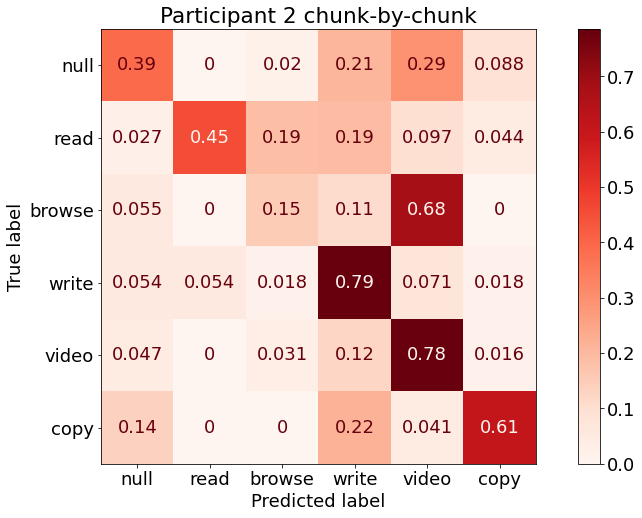


Started training for participant 3

Training data shape:   (2858, 1280, 2)   labels shape: (2858, 6)
Validation data shape: (715, 1280, 2)     labels shape: (715, 6)
Testing data shape:    (632, 1280, 2)    labels shape: (632, 6)

Epoch 1/25
159/159 [==============================] - 3s 11ms/step - loss: 4.7324 - accuracy: 0.2463 - val_loss: 2.0861 - val_accuracy: 0.3119
Epoch 2/25
159/159 [==============================] - 1s 9ms/step - loss: 1.9659 - accuracy: 0.3030 - val_loss: 1.8935 - val_accuracy: 0.3622
Epoch 3/25
159/159 [==============================] - 2s 9ms/step - loss: 1.8374 - accuracy: 0.3390 - val_loss: 1.8157 - val_accuracy: 0.3650
Epoch 4/25
159/159 [==============================] - 1s 9ms/step - loss: 1.7732 - accuracy: 0.3653 - val_loss: 1.6996 - val_accuracy: 0.4112
Epoch 5/25
159/159 [==============================] - 1s 9ms/step - loss: 1.7296 - accuracy: 0.3684 - val_loss: 1.6945 - val_accuracy: 0.3958
Epoch 6/25
159/159 [==============================] - 1s 

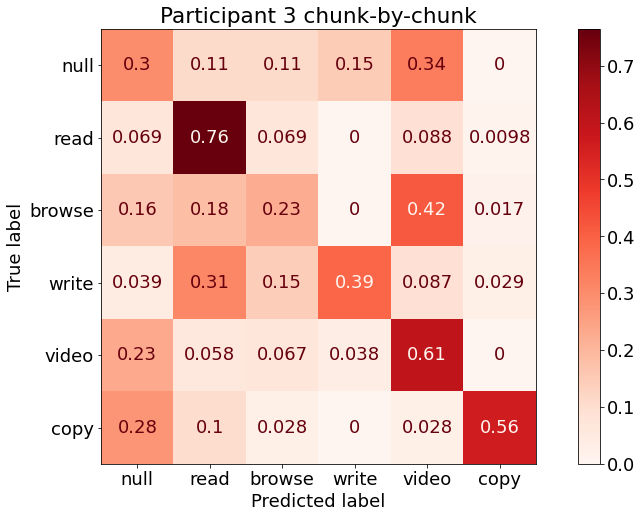


Started training for participant 4

Training data shape:   (2913, 1280, 2)   labels shape: (2913, 6)
Validation data shape: (729, 1280, 2)     labels shape: (729, 6)
Testing data shape:    (563, 1280, 2)    labels shape: (563, 6)

Epoch 1/25
162/162 [==============================] - 3s 12ms/step - loss: 4.7618 - accuracy: 0.2084 - val_loss: 1.9973 - val_accuracy: 0.2291
Epoch 2/25
162/162 [==============================] - 2s 10ms/step - loss: 1.9117 - accuracy: 0.3162 - val_loss: 1.8155 - val_accuracy: 0.3608
Epoch 3/25
162/162 [==============================] - 2s 9ms/step - loss: 1.7660 - accuracy: 0.3694 - val_loss: 1.7684 - val_accuracy: 0.3265
Epoch 4/25
162/162 [==============================] - 2s 10ms/step - loss: 1.7012 - accuracy: 0.3938 - val_loss: 1.7302 - val_accuracy: 0.3553
Epoch 5/25
162/162 [==============================] - 2s 9ms/step - loss: 1.6679 - accuracy: 0.3951 - val_loss: 1.6329 - val_accuracy: 0.4019
Epoch 6/25
162/162 [==============================] - 2

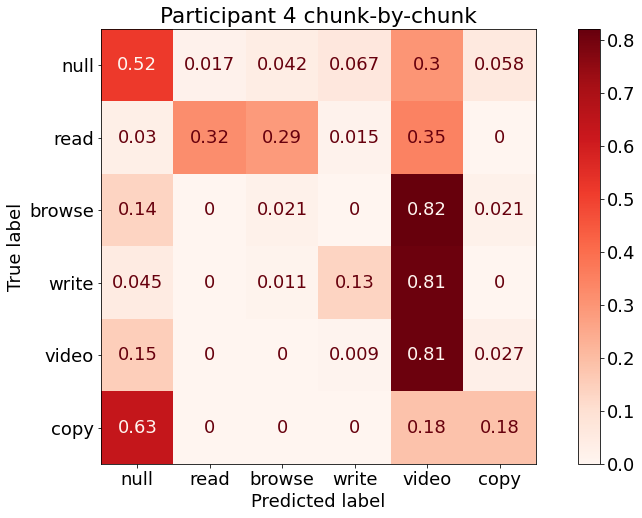


Started training for participant 5

Training data shape:   (2925, 1280, 2)   labels shape: (2925, 6)
Validation data shape: (732, 1280, 2)     labels shape: (732, 6)
Testing data shape:    (548, 1280, 2)    labels shape: (548, 6)

Epoch 1/25
163/163 [==============================] - 3s 13ms/step - loss: 3.8843 - accuracy: 0.2978 - val_loss: 1.9264 - val_accuracy: 0.2555
Epoch 2/25
163/163 [==============================] - 2s 10ms/step - loss: 1.8462 - accuracy: 0.3323 - val_loss: 1.8257 - val_accuracy: 0.3101
Epoch 3/25
163/163 [==============================] - 2s 10ms/step - loss: 1.7754 - accuracy: 0.3549 - val_loss: 1.7619 - val_accuracy: 0.3197
Epoch 4/25
163/163 [==============================] - 2s 10ms/step - loss: 1.7217 - accuracy: 0.3641 - val_loss: 1.7095 - val_accuracy: 0.3538
Epoch 5/25
163/163 [==============================] - 2s 10ms/step - loss: 1.6989 - accuracy: 0.3703 - val_loss: 1.6458 - val_accuracy: 0.3566
Epoch 6/25
163/163 [==============================] -

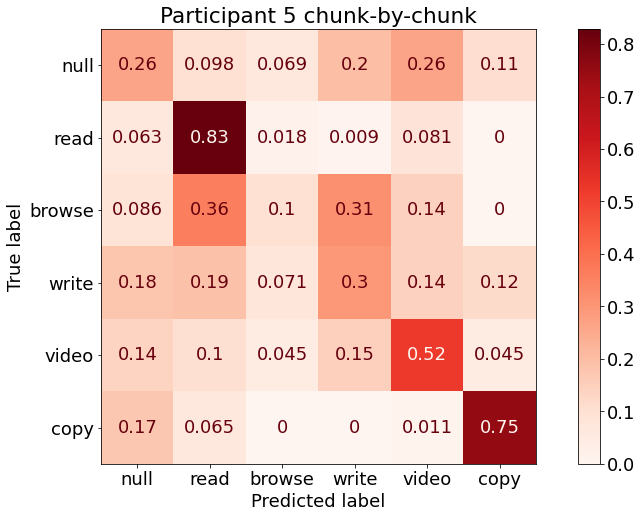


Started training for participant 6

Training data shape:   (2904, 1280, 2)   labels shape: (2904, 6)
Validation data shape: (727, 1280, 2)     labels shape: (727, 6)
Testing data shape:    (574, 1280, 2)    labels shape: (574, 6)

Epoch 1/25
162/162 [==============================] - 3s 12ms/step - loss: 4.3423 - accuracy: 0.2569 - val_loss: 2.0043 - val_accuracy: 0.2724
Epoch 2/25
162/162 [==============================] - 2s 10ms/step - loss: 1.8977 - accuracy: 0.3485 - val_loss: 1.9643 - val_accuracy: 0.2724
Epoch 3/25
162/162 [==============================] - 2s 10ms/step - loss: 1.7943 - accuracy: 0.3795 - val_loss: 1.7371 - val_accuracy: 0.4209
Epoch 4/25
162/162 [==============================] - 2s 10ms/step - loss: 1.7467 - accuracy: 0.4060 - val_loss: 1.7762 - val_accuracy: 0.4030
Epoch 5/25
162/162 [==============================] - 2s 10ms/step - loss: 1.7284 - accuracy: 0.4125 - val_loss: 1.6870 - val_accuracy: 0.4484
Epoch 6/25
162/162 [==============================] -

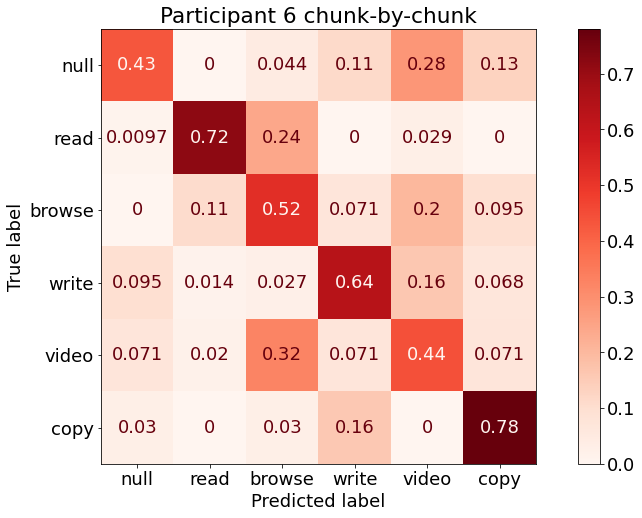


Started training for participant 7

Training data shape:   (2963, 1280, 2)   labels shape: (2963, 6)
Validation data shape: (741, 1280, 2)     labels shape: (741, 6)
Testing data shape:    (501, 1280, 2)    labels shape: (501, 6)

Epoch 1/25
165/165 [==============================] - 3s 13ms/step - loss: 4.8987 - accuracy: 0.2555 - val_loss: 2.1110 - val_accuracy: 0.3023
Epoch 2/25
165/165 [==============================] - 2s 10ms/step - loss: 1.9646 - accuracy: 0.3476 - val_loss: 1.8754 - val_accuracy: 0.3657
Epoch 3/25
165/165 [==============================] - 2s 10ms/step - loss: 1.8279 - accuracy: 0.3945 - val_loss: 1.7574 - val_accuracy: 0.4197
Epoch 4/25
165/165 [==============================] - 2s 10ms/step - loss: 1.7512 - accuracy: 0.4269 - val_loss: 1.7672 - val_accuracy: 0.4049
Epoch 5/25
165/165 [==============================] - 2s 10ms/step - loss: 1.6937 - accuracy: 0.4452 - val_loss: 1.7448 - val_accuracy: 0.4305
Epoch 6/25
165/165 [==============================] -

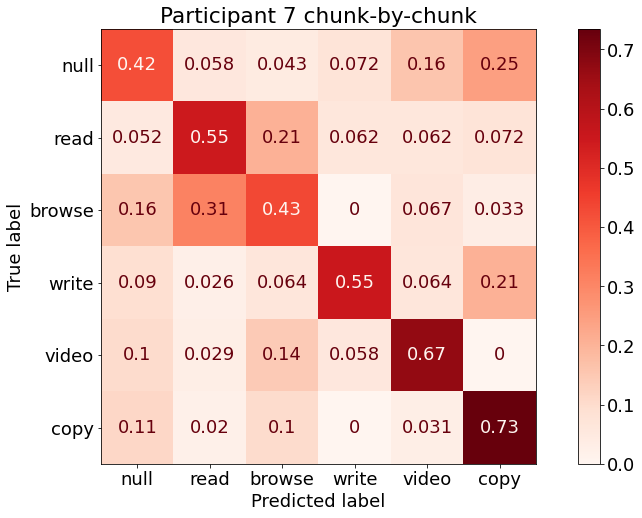


Started training for participant 8

Training data shape:   (2925, 1280, 2)   labels shape: (2925, 6)
Validation data shape: (732, 1280, 2)     labels shape: (732, 6)
Testing data shape:    (548, 1280, 2)    labels shape: (548, 6)

Epoch 1/25
163/163 [==============================] - 3s 12ms/step - loss: 5.3278 - accuracy: 0.2615 - val_loss: 2.1095 - val_accuracy: 0.3183
Epoch 2/25
163/163 [==============================] - 2s 10ms/step - loss: 2.0138 - accuracy: 0.3193 - val_loss: 1.9071 - val_accuracy: 0.3525
Epoch 3/25
163/163 [==============================] - 2s 10ms/step - loss: 1.8896 - accuracy: 0.3624 - val_loss: 1.7814 - val_accuracy: 0.4112
Epoch 4/25
163/163 [==============================] - 2s 10ms/step - loss: 1.7672 - accuracy: 0.4209 - val_loss: 1.7198 - val_accuracy: 0.4440
Epoch 5/25
163/163 [==============================] - 2s 10ms/step - loss: 1.7130 - accuracy: 0.4390 - val_loss: 1.7227 - val_accuracy: 0.4467
Epoch 6/25
163/163 [==============================] -

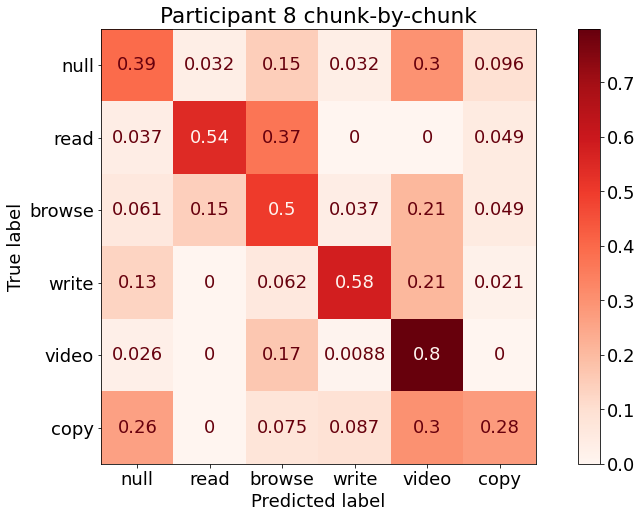

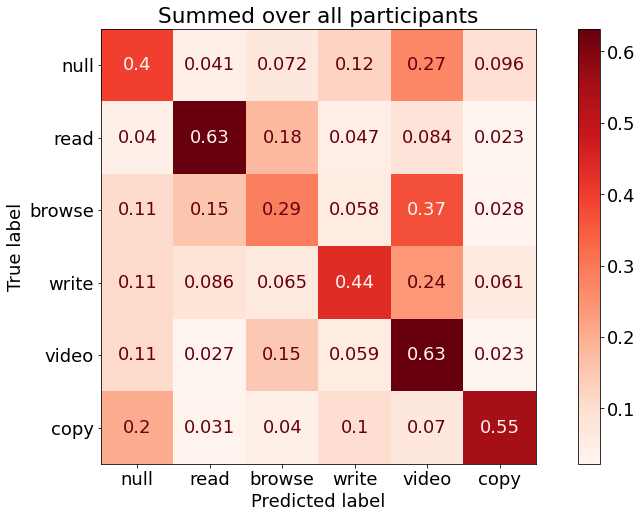

In [22]:
# TESTING REGULAR CNN

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model


def compile_model(input_shape = (625, 4), output_nodes = 6, cnn_activation = 'relu', dense_activation = 'relu', dropout_rate = 0.2):
  model = Sequential()

  model.add(Input(shape = input_shape))

  model.add(Conv1D(8, 3, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(16, 5, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(32, 7, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(64, 9, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Flatten())

  # Use half as many nodes as output of the flatten layer
  model.add(Dense(2336, activation=dense_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(Dropout(dropout_rate))
  
  model.add(Dense(output_nodes, activation='softmax'))

  opt = Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

def collect(trues, preds):
  # 2D dictionary
  # hierarchy: true label -> 'total'         -> how many times that label appears in the test set
  #                       -> predicted label -> how many times the model predicted that label
  predictions = {}
  for c in np.unique(trues):
    predictions[c] = defaultdict(lambda: 0)

  # Count all predictions
  for true_label, pred_label in zip(trues, preds):
    #predictions[true_label]['total'] += 1
    predictions[true_label][pred_label] += 1

  # Summarize all predictions
  true_labels_summed = []
  predictions_summed = []

  for true, d in predictions.items():
    true_labels_summed.append(true)
    predictions_summed.append(max(d, key=d.get))

  return true_labels_summed, predictions_summed

def plot_conf_matrix_per_participant(participant, trues, preds):
  fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trues, preds, normalize = 'true')).plot(cmap=plt.cm.Reds)
  plt.title(f"Participant {participant} chunk-by-chunk")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.show()

def plot_summed_conf_matrix(trues, preds):
  fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trues, preds, normalize = 'true')).plot(cmap=plt.cm.Reds)
  plt.title(f"Summed over all participants")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  #ax.xaxis.set_ticks_position('top')
  #ax.xaxis.set_label_position('top')
  plt.savefig(f"summed.png")
  plt.show()

# For each test, one participant is the test participant (not included in the training set).
first_iteration = True
chunk_by_chunk_true_labels = []
chunk_by_chunk_predictions = []
summed_true_labels = []
summed_predictions = []

for testing_participant in range(1, 9):
  training_participants = list(range(1, 9))
  training_participants.remove(testing_participant)

  # Get concatenated tables for fitting StandardScalers.
  X_train, y_train = concat_datasets(datasets_dict, training_participants, data_columns) # The returned y_train and y_test lists aren't actually used.
  X_test, y_test = concat_datasets(datasets_dict, [testing_participant], data_columns)
  X_train = pd.DataFrame(data = X_train, columns = data_columns)
  X_test = pd.DataFrame(data = X_test, columns = data_columns)

  # Fit the scalers on both whole datasets.
  train_scaler = StandardScaler(copy = True).fit(X_train) # These scalers do NOT change the values in-place, but return a copy.
  test_scaler = StandardScaler(copy = True).fit(X_test)

  # Standardize the training and test sets.
  standardized_dict = standardize({}, datasets_dict, training_participants, data_columns, train_scaler) 
  standardized_dict = standardize(standardized_dict, datasets_dict, [testing_participant], data_columns, test_scaler)

  # Split each class in dataset into chunks. Can be used for sliding window sampling (sliding_window_step argument must be given).
  # Also subtracts 1 from all labels so they start from 0.
  chunk_size = 1280
  sliding_window_step = 640
  split_datasets(standardized_dict, data_columns, chunk_size, sliding_window_step)

  # One-hot encode labels
  one_hot_encode_labels(standardized_dict)

  # Concatenate chunks
  X_train, y_train = concat_chunks(standardized_dict, training_participants)
  X_test, y_test = concat_chunks(standardized_dict, [testing_participant])

  # Further divide the training set into training and validation sets
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2) # this also shuffles train and val sets

  # Makes a fresh model for every person
  model = compile_model(input_shape = X_train.shape[1:], output_nodes = y_train.shape[1])

  if first_iteration: # print the model summary only on the first iteration
    model.summary()
    first_iteration = False
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  print(f"\nStarted training for participant {testing_participant}\n")
  print(f"Training data shape:   {X_train.shape}   labels shape: {y_train.shape}")
  print(f"Validation data shape: {X_val.shape}     labels shape: {y_val.shape}")
  print(f"Testing data shape:    {X_test.shape}    labels shape: {y_test.shape}\n")

  #model.fit(X_train, y_train, batch_size=18, epochs=25, validation_data=(X_val, y_val), verbose=1)

  # Get the model's predictions for each chunk
  print(f"\nTesting participant {testing_participant}\n")
  true_labels = [np.argmax(el) for el in y_test]
  predictions = [np.argmax(el) for el in model.predict(X_test)]

  plot_conf_matrix_per_participant(testing_participant, true_labels, predictions)

  chunk_by_chunk_true_labels.append(true_labels)
  chunk_by_chunk_predictions.append(predictions)

  # Collect predictions of the entire signal
  #sum_true, sum_pred = collect(true_labels, predictions)
  #summed_true_labels.append(sum_true)
  #summed_predictions.append(sum_pred)

  #break

chunk_by_chunk_true_labels = np.concatenate(chunk_by_chunk_true_labels)
chunk_by_chunk_predictions = np.concatenate(chunk_by_chunk_predictions)
#summed_true_labels = np.concatenate(summed_true_labels)
#summed_predictions = np.concatenate(summed_predictions)

plot_summed_conf_matrix(chunk_by_chunk_true_labels, chunk_by_chunk_predictions)